#Dravidian Language Identification - VarDial2021 

This notebook contains the CNN used by Team Phlyers for the DLI shared task at VarDial2021. The network is an adaptation of the CNN presented in Butnaru and Ionescu (2019).

The first few blocks are needed to set up the directory.

In [29]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
%cd /content/drive/My Drive/Colab Notebooks/DLI-VarDial2021


/content/drive/My Drive/Colab Notebooks/DLI-VarDial2021


The next block loads the data and performs preprocessing.

In [31]:
from io import open
from collections import defaultdict, Counter
import string 
import random

'''
The code has been adapted from:

Convolutional Neural Networks Tutorial in PyTorch 
(https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/)

NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN
by Sean Robertson
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
'''

##############################
# Load the data and preprocess
##############################

sentences = open('Dravidianlanid-Vardial2021-train.tsv').readlines()

#Fixed seed
random.seed(10)
random.shuffle(sentences)

data = defaultdict(list)
test = []

#Split the data into training and test, 80/20 split
i=0
for line in sentences:
    if len(line.split('\t')) == 2:
        sample, label = line.split('\t')
        if i< 13337: #this is the cutoff to extract 4/5 of the dataset
          sample_new = sample.translate(line.maketrans('', '', string.punctuation+'0123456789'))
          data[label.rstrip()].append(sample_new)
        else: #everything else goes in the test set
          sample_new = sample.translate(line.maketrans('', '', string.punctuation+'0123456789'))
          test.append((sample_new, label.rstrip()))
        i+=1

#Print labels
label_list = list(data.keys())
print("Labels:")
print(label_list)

#Load training and test set
X_train = []
y_train = []

for key in label_list:
  for sentence in data[key]:
    y_train.append(key)
    X_train.append(sentence)

X_test = [X for X, _ in test]
y_test = [y for _, y in test]

#Print number of training sentences, test sentences and labels
print('# of train sentences:', len(X_train))
print('# of train labels:', len(set(y_train)))
print('# of test sentences:', len(X_test))
print('# of test labels:', len(set(y_test)))

##################
#Characters 
#################

#Store the 100 most frequent characters that appear in training. 
all_letters = Counter(''.join(X_train))
letters = [letter for letter, _ in all_letters.most_common(100)]
letters = ''.join(letters)

n_letters = len(letters)
print('# of characters:', n_letters)

# Map the characters into a list of indeces, that you use to create the tensors
dic_letters = dict(zip(letters, range(1, n_letters+1)))

Labels:
['Tamil', 'Malayalam', 'Kannada', 'other-language']
# of train sentences: 13337
# of train labels: 4
# of test sentences: 3335
# of test labels: 4
# of characters: 100


Next, we define the hyper-parameters of the neural network and the size of the training dataset

In [32]:
##################
#Hyper-parameters
##################

learning_rate = 0.001
num_epochs = 10
batch_size = 256
n_sentences =  25000

In this block we perform balanced sampling, with the option of augmenting the data by shuffling the sentences.

In [33]:
##################
#Data Augmentation
#################

#Perform balanced sampling

#Add sentences, no shuffling
def add_sentences():
  for i in range(n_sentences):
    lang = random.choice(list(label_list)) #Select a language at random
    sentence = random.choice(data[lang]) #Select a sentence at random
    y_train.append(lang)
    X_train.append(sentence)

#Add sentences, shuffling
def add_sentences_shuffling():
  for i in range(n_sentences):
    lang = random.choice(list(label_list)) #Select a language at random
    sentence = random.choice(data[lang]) #Select a sentence at random
    new_sentence = sentence.split()
    random.shuffle(new_sentence)
    new_sentence = ' '.join(new_sentence)
    y_train.append(lang)
    X_train.append(new_sentence)

#Call the function to perform balanced sampling
add_sentences_shuffling()

print('# of train+augmented sentences:', len(X_train))
print('# of train_augmented labels:', len(set(y_train)))

# of train+augmented sentences: 38337
# of train_augmented labels: 4


The next block contains some helper functions that are needed to transform our input data in Tensors.

In [34]:
import torch

###################
# Helper functions
###################

# Get the letter index
def letterToIndex(letter):
    if letter in dic_letters:
        return dic_letters[letter]
    return 0

#Turns a single line into a tensor
def lineToTensor(line):
    tensor = torch.zeros(n_letters+1, 160)
    for li, letter in enumerate(line[:160]):
        tensor[letterToIndex(letter)][li] = 1 
    return tensor

#Turns an batch of lines into a batch of tensors
def linesToTensors(lines):
    tensor = torch.zeros(batch_size, n_letters+1, 160)
    for batch, line in enumerate(lines):
      for li, letter in enumerate(line[:160]):
          tensor[batch][letterToIndex(letter)][li] = 1 
    return tensor

#Turns categories it tensors
def categoriesToTensors(categories):
    labels = torch.zeros(len(categories),dtype=torch.long)
    for i, label in enumerate(categories):
      labels[i] = label_list.index(label)
    return labels

#Turns tensors into labels
def categoryFromOutput(output):
  return label_list[int(output)]

#Check that the category index is correct

tensor = categoriesToTensors(['Tamil'])
print(tensor)
print(categoryFromOutput(tensor))

tensor_2 = categoriesToTensors(['Malayalam'])
print(tensor_2)
print(categoryFromOutput(tensor_2))

tensor_3 = categoriesToTensors(['Kannada'])
print(tensor_3)
print(categoryFromOutput(tensor_3))

tensor_4 = categoriesToTensors(['other-language'])
print(tensor_4)
print(categoryFromOutput(tensor_4))


tensor([0])
Tamil
tensor([1])
Malayalam
tensor([2])
Kannada
tensor([3])
other-language


This is a class based on the DataLoader class that we will use to load the data.

In [35]:
from torch.utils.data import DataLoader, Dataset

class MyClass(Dataset):
    def __init__(self, training, labels):
        self.training = training
        self.labels = labels

    def __len__(self):
        return len(self.training)

    def __getitem__(self, idx):
        return (self.training[idx], self.labels[idx])

training_dataset = MyClass(X_train, y_train)
dev_dataset = MyClass(X_test, y_test)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=True, drop_last=True)

This is the CNN adapted from Butnaru and Ionescu (2019).

In [36]:
import torch.nn as nn
from torch.autograd import Variable

######################################################################
# Creating the Network
# ====================


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(101, 128, kernel_size=7), nn.Threshold(threshold=0.000001, value=0), nn.MaxPool1d(3, stride=3))
        self.conv2 = nn.Sequential(nn.Conv1d(128, 128, kernel_size=7), nn.Threshold(threshold=0.000001, value=0), nn.MaxPool1d(3, stride=3))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 128, kernel_size=3), nn.Threshold(threshold=0.000001, value=0), nn.MaxPool1d(3, stride=3))
        self.fc1 = nn.Sequential(nn.Linear(512, 1000), nn.Threshold(threshold=0.000001, value=0) ,nn.Dropout())
        #For these two layers they do not specify the size. This was fine-tuned by us.
        self.fc2 = nn.Sequential(nn.Linear(1000, 500), nn.Threshold(threshold=0.000001, value=0) ,nn.Dropout())
        self.fc3 = nn.Linear(500, 4)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        softmax = nn.Softmax(dim=1)

        return softmax(out)

model = Net()
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print('The CNN is ready.')


The CNN is ready.


This is the training phase. 

In the process, we plot the accuracy on the training and on the development data on a Matplotlib plot.


Training. Epoch- 0 F-score: 0.5263999580536913
Development. Epoch- 0 F-score: 0.8326836581709145
Training. Epoch- 1 F-score: 0.7450188758389261
Development. Epoch- 1 F-score: 0.8593703148425788
Training. Epoch- 2 F-score: 0.8270763422818792
Development. Epoch- 2 F-score: 0.8326836581709145
Training. Epoch- 3 F-score: 0.8531617030201344
Development. Epoch- 3 F-score: 0.8740629685157422
Training. Epoch- 4 F-score: 0.8897860738255033
Development. Epoch- 4 F-score: 0.8821589205397301
Training. Epoch- 5 F-score: 0.9031826761744967
Development. Epoch- 5 F-score: 0.8740629685157422
Training. Epoch- 6 F-score: 0.9025796979865772
Development. Epoch- 6 F-score: 0.870464767616192
Training. Epoch- 7 F-score: 0.9056732382550335
Development. Epoch- 7 F-score: 0.8929535232383808
Training. Epoch- 8 F-score: 0.919253355704698
Development. Epoch- 8 F-score: 0.8338830584707646
Training. Epoch- 9 F-score: 0.9140625
Development. Epoch- 9 F-score: 0.8863568215892054


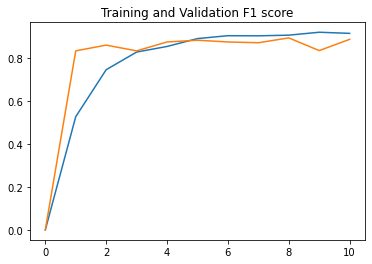

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Train the model on the development dataset, and evaluate it on the test dataset
# Print trainining and evaluation accuracies

loss_list = []
training_accuracy = [0]
dev_accuracy = [0]

for epoch in range(num_epochs):

  predicted_labels = []
  correct_labels = []

  for i, (sentences, category) in enumerate(training_dataloader):
    tensors = linesToTensors(sentences)
    tensors = tensors.to("cuda")
    labels = categoriesToTensors(category)
    labels = labels.to("cuda")
    outputs = model(tensors)
    outputs = outputs.to("cuda")

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the training accuracys
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc = correct / total

    predicted_labels.extend([int(label) for label in predicted])
    correct_labels.extend([int(label) for label in labels])

  #Store training accuracy
  training_accuracy.append(f1_score(predicted_labels, correct_labels, average='micro'))
  print('Training. Epoch-', epoch, 'F-score:', f1_score(predicted_labels, correct_labels, average='micro'))

  #Check validation accuracy
  total = len(y_test)
  predicted = []
  correct = []

  for i, (sentence, category) in enumerate(zip(X_test, y_test)):
    tensor = torch.reshape(lineToTensor(sentence), (1, n_letters+1, 160))
    tensor = tensor.to("cuda")
    outputs = model(tensor)
    outputs = outputs.to("cpu")

    label = Variable(torch.LongTensor([label_list.index(category)]))

    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction)
    correct.append(label)
  dev_accuracy.append(f1_score(predicted, correct, average='micro'))
  print('Development. Epoch-', epoch, 'F-score:', f1_score(predicted, correct, average='micro'))

#Plot training and evaluation accuracy
n_epochs = [iter for iter in range(len(training_accuracy))]
plt.plot(n_epochs, training_accuracy)
plt.plot(n_epochs, dev_accuracy)
plt.title('Training and Validation F1 score')
plt.show()


